In [ ]:
!pip install wandb

     |████████████████████████████████| 2.1MB 10.7MB/s 
     |████████████████████████████████| 163kB 27.0MB/s 
     |████████████████████████████████| 133kB 38.3MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2d954e7dfe0a8a7f68896dd4d30d220e8ecacf8ba1bb0ffca5de7a0187fc2d1a
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=92d43e56ed7efbbef2f1821cc00fee1dffd0c57b091e49956a694cc287916f00
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools



# **Part A: Training from Scratch**

---

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import PILimport numpy as np
import tensorflow as tf
import numpy as np
import matplotlib
import h5py
import json
import cv2
import os

In [ ]:
import wandb
wandb.login()
from wandb.keras import WandbCallback
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **Load the Data:**


---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data Path
train_path = '/content/drive/MyDrive/DL_Assignment 2/train'
test_path = '/content/drive/MyDrive/DL_Assignment 2/test'
val_path = '/content/drive/MyDrive/DL_Assignment 2/val'

image_size = 224

#Load Data
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory(
            train_path,
            target_size=(image_size, image_size),
            shuffle = True)

test = test_datagen.flow_from_directory(
            test_path,
            target_size=(image_size, image_size),
            shuffle = True)

val = val_datagen.flow_from_directory(
          val_path,
          target_size=(image_size, image_size),
          shuffle = True)

image_batch_train, label_batch_train = next(iter(train))
labels = sorted(train.class_indices.items(), key = lambda pair:pair[1])
labels = np.array([key.title() for key, value in labels])

class_mapping = train.class_indices
print(class_mapping)

X, y = next(train)
Y = np.argmax(y, axis = 1)

print(Y)

Found 9000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
{'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
[3 8 9 5 2 3 4 6 5 2 1 2 6 1 2 5 0 6 6 9 4 1 0 3 9 7 3 5 8 1 0 6]


##**Visualise the Data:**

---

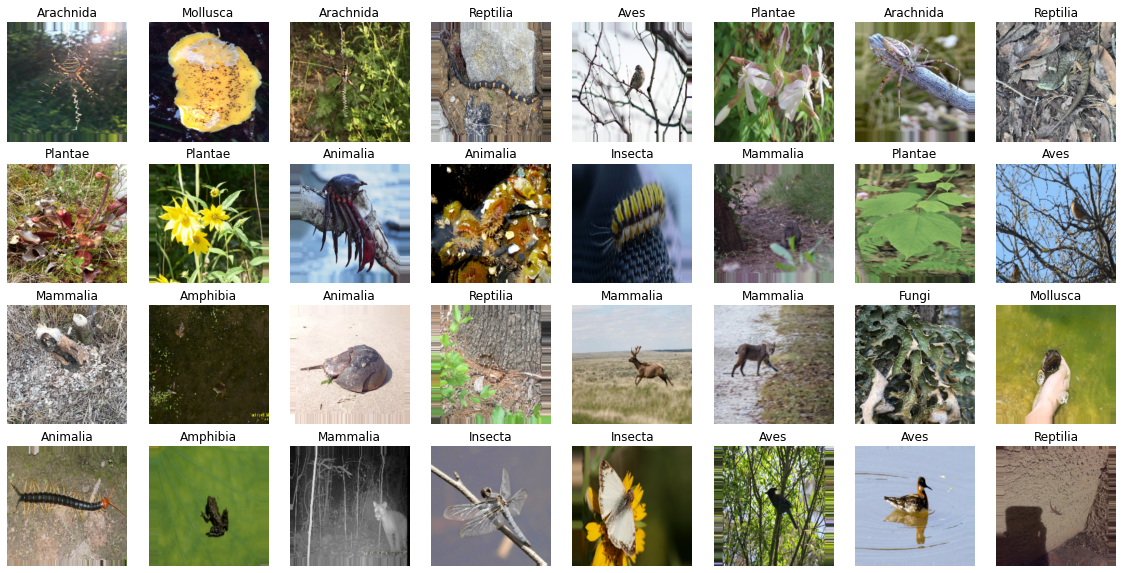

In [ ]:
def GetKey(val):
   for key, value in class_mapping.items():
      if val == value:
         return key
      else:
        pass

def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(nrows, ncols),
                     axes_pad=0.3,
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis('off')
        ax.set_title(GetKey(label_list[i]))
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(X, 4, 8,label_list = Y, show_labels = True, figsize = (20,10))

##**Setup Sweeps:**

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epoch': {
            'values': [5, 10]
        },
        'batch_size': {
            'values': [32, 64, 128, 256]
        },
        'K1': {
            'values': [16, 32, 64]
        },
        'K2': {
            'values': [16, 32, 64]
        },
        'K3': {
            'values': [16, 32, 64]
        },
        'K4': {
            'values': [16, 32, 64]
        },
        'K5': {
            'values': [16, 32, 64]
        },
        'F': {
            'values': [3, 5, 7]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'w_decay': {
            'values': [0.0, 0.0005, 0.5]
        },
        'augment': {
            'values': ['true', 'false']
        },
        'batch_normalization': {
            'values': ['true']
        },
        'dense_units': {
            'values': [128, 256, 512]
        },
        'activation': {
            'values': ['relu', 'tanh']#, 'sigmoid']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project = 'cs6910-assignment-2')

Create sweep with ID: xttvfgxi
Sweep URL: https://wandb.ai/sushane/cs6910-assignment-2/sweeps/xttvfgxi


In [ ]:
def Convolution_Network():

    #Data Path
    train_path = '/content/drive/MyDrive/DL_Assignment 2/train'
    test_path = '/content/drive/MyDrive/DL_Assignment 2/test'
    val_path = '/content/drive/MyDrive/DL_Assignment 2/val'

    #Default values
    image_size = 224
    w_init = 'he_normal'
    S = 2

    #Sweep defaults
    config_defaults = {
        'epoch': 5,
        'batch_size': 32,
        'K1': 32,
        'K2': 32,
        'K3': 32,
        'K4': 32,
        'K5': 32,
        'F': 3,
        'dropout': 0.2,
        'w_decay': 0.0,
        'augment': 'true',
        'batch_normalization': 'false',
        'dense_units': 64,
        'activation': 'relu'
    }
     
    wandb.init(project = 'cs6910-assignment-2', config = config_defaults)
    config = wandb.config
    name = "BS=" + str(config.batch_size) + "_ACT=" + str(config.activation) + "_Dropout=" + str(config.dropout)
    wandb.init().name = name

    epoch = config.epoch
    batch_size = config.batch_size
    K1 = config.K1
    K2 = config.K2
    K3 = config.K3
    K4 = config.K4
    K5 = config.K5
    F = config.F
    dropout = config.dropout
    w_decay = config.w_decay
    augment = config.augment
    batch_normalization = config.batch_normalization
    dense_units = config.dense_units
    dense_units = 64
    activation = config.activation

    #Load Data
    if augment == 'true':
      train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
    else:
      train_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)

    train = train_datagen.flow_from_directory(train_path, target_size=(image_size, image_size), shuffle = True, batch_size=batch_size)

    test = test_datagen.flow_from_directory(test_path, target_size=(image_size, image_size), shuffle = True, batch_size=batch_size)

    val = val_datagen.flow_from_directory(val_path, target_size=(image_size, image_size), shuffle = True, batch_size=batch_size)

    image_batch_train, label_batch_train = next(iter(train))
    labels = sorted(train.class_indices.items(), key = lambda pair:pair[1])
    labels = np.array([key.title() for key, value in labels])
    no_of_labels = len(labels)

    #Prepare Callback

    model_path = './fm_cnn_BN.h5'

    callbacks = [
                 EarlyStopping(
                     monitor = 'val_accuracy', patience = 3, mode = 'max', verbose = 1),
                 ModelCheckpoint(
                     model_path, monitor = 'val_accuracy', save_best_only = True, mode = 'max', verbose = 0) 
    ]

    #CNN
    model = Sequential()

    if activation == 'relu':
      w_init = 'he_normal'
    else:
      w_init = 'glorot_normal'
 
    
    #Layer 1
    model.add(Conv2D(filters = K1, kernel_size = (F,F), input_shape = image_batch_train.shape[1:], padding ='same', kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = S))

    #Layer 2
    model.add(Conv2D(filters = K2, kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

    #Layer 3
    model.add(Conv2D(filters = K3, kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

    #Layer 4
    model.add(Conv2D(filters = K4, kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

    #Layer 5
    model.add(Conv2D(filters = K5, kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

    #FC1
    model.add(Flatten())
    model.add(Dense(dense_units, kernel_initializer = w_init))
    if batch_normalization == 'true':
      model.add(BatchNormalization())
    else :
      pass

    model.add(Activation('relu'))
    model.add(Dropout(dropout))

    #Output layer
    model.add(Dense(no_of_labels, kernel_initializer = 'glorot_normal'))
    model.add(Activation('softmax'))

    model.compile(optimizer = 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
    hist = model.fit(train, epochs = epoch, validation_data = val, batch_size = batch_size, callbacks = callbacks)
    model.summary()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    for i in range(epoch):
      wandb.log({'training_loss': loss[i]})
      wandb.log({'validation_loss': val_loss[i]})
      wandb.log({'training_accuracy': acc[i]})
      wandb.log({'validation_accuracy': val_acc[i]})
                            

In [ ]:
wandb.agent(sweep_id, function = Convolution_Network)

wandb: Agent Starting Run: a0q5u9h8 with config:
wandb: 	F: 5
wandb: 	K1: 16
wandb: 	K2: 32
wandb: 	K3: 64
wandb: 	K4: 64
wandb: 	K5: 64
wandb: 	activation: relu
wandb: 	augment: true
wandb: 	batch_normalization: true
wandb: 	batch_size: 32
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epoch: 5
wandb: 	w_decay: 0
wandb: Currently logged in as: sushane (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Found 9000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/5
282/282 [==============================] - 3296s 12s/step - loss: 2.2946 - accuracy: 0.1994 - val_loss: 2.0969 - val_accuracy: 0.2450
Epoch 2/5
282/282 [==============================] - 1557s 6s/step - loss: 2.0624 - accuracy: 0.2687 - val_loss: 2.0663 - val_accuracy: 0.3030
Epoch 3/5
282/282 [==============================] - 1555s 6s/step - loss: 1.9619 - accuracy: 0.3067 - val_loss: 2.0197 - val_accuracy: 0.3020
Epoch 4/5
282/282 [==============================] - 1549s 5s/step - loss: 1.8608 - accuracy: 0.3428 - val_loss: 2.0286 - val_accuracy: 0.2890
Epoch 5/5
282/282 [==============================] - 1556s 6s/step - loss: 1.8351 - accuracy: 0.3522 - val_loss: 2.2892 - val_accuracy: 0.2650
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape

training_loss,1.84764
_runtime,9548
_timestamp,1618171099
_step,19
validation_loss,2.28924
training_accuracy,0.35056
validation_accuracy,0.265


training_loss,█▅▃▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_loss,▃▂▁▁█
training_accuracy,▁▄▆▇█
validation_accuracy,▁██▆▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: llo7b64w with config:
wandb: 	F: 5
wandb: 	K1: 32
wandb: 	K2: 32
wandb: 	K3: 16
wandb: 	K4: 16
wandb: 	K5: 64
wandb: 	activation: relu
wandb: 	augment: false
wandb: 	batch_normalization: true
wandb: 	batch_size: 32
wandb: 	dense_units: 512
wandb: 	dropout: 0.3
wandb: 	epoch: 5
wandb: 	w_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Found 9000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/5
282/282 [==============================] - 1685s 6s/step - loss: 2.3413 - accuracy: 0.1985 - val_loss: 2.5647 - val_accuracy: 0.1530
Epoch 2/5
282/282 [==============================] - 1689s 6s/step - loss: 2.0239 - accuracy: 0.2937 - val_loss: 2.0980 - val_accuracy: 0.2690
Epoch 3/5
282/282 [==============================] - 1686s 6s/step - loss: 1.9044 - accuracy: 0.3254 - val_loss: 1.9815 - val_accuracy: 0.3150
Epoch 4/5
282/282 [==============================] - 1689s 6s/step - loss: 1.8173 - accuracy: 0.3578 - val_loss: 1.9657 - val_accuracy: 0.3150
Epoch 5/5
282/282 [==============================] - 1690s 6s/step - loss: 1.7554 - accuracy: 0.3889 - val_loss: 2.0116 - val_accuracy: 0.3280
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv

training_loss,1.76555
_runtime,8444
_timestamp,1618179580
_step,19
validation_loss,2.01156
training_accuracy,0.37833
validation_accuracy,0.328


training_loss,█▅▃▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_loss,█▃▁▁▂
training_accuracy,▁▄▅▇█
validation_accuracy,▁▆▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wfmgop71 with config:
wandb: 	F: 5
wandb: 	K1: 64
wandb: 	K2: 16
wandb: 	K3: 32
wandb: 	K4: 32
wandb: 	K5: 64
wandb: 	activation: relu
wandb: 	augment: false
wandb: 	batch_normalization: true
wandb: 	batch_size: 256
wandb: 	dense_units: 512
wandb: 	dropout: 0.3
wandb: 	epoch: 5
wandb: 	w_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Found 9000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/5


## **Visualise Filters:**


*   RGB Filters, each of the 3 channels of 32 Filters each.


---



Epoch 1/15
282/282 [==============================] - 4434s 16s/step - loss: 3.1354 - accuracy: 0.1451 - val_loss: 2.1642 - val_accuracy: 0.2025
Epoch 2/15
282/282 [==============================] - 261s 924ms/step - loss: 2.1181 - accuracy: 0.2322 - val_loss: 2.0897 - val_accuracy: 0.2590
Epoch 3/15
282/282 [==============================] - 255s 904ms/step - loss: 2.0292 - accuracy: 0.2731 - val_loss: 1.9542 - val_accuracy: 0.3070
Epoch 4/15
282/282 [==============================] - 256s 909ms/step - loss: 1.9757 - accuracy: 0.2987 - val_loss: 1.9163 - val_accuracy: 0.3255
Epoch 5/15
282/282 [==============================] - 258s 916ms/step - loss: 1.8952 - accuracy: 0.3314 - val_loss: 1.9654 - val_accuracy: 0.3185
Epoch 6/15
282/282 [==============================] - 258s 914ms/step - loss: 1.8617 - accuracy: 0.3427 - val_loss: 1.8485 - val_accuracy: 0.3625
Epoch 7/15
282/282 [==============================] - 258s 915ms/step - loss: 1.8232 - accuracy: 0.3482 - val_loss: 1.8164 - 

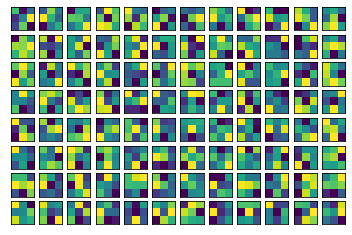

Training Accuracy [0.1648888885974884, 0.24244444072246552, 0.2822222113609314, 0.30522221326828003, 0.32100000977516174, 0.3490000069141388, 0.35555556416511536, 0.37388888001441956, 0.38499999046325684, 0.40488889813423157, 0.42233332991600037, 0.43444445729255676, 0.44922223687171936, 0.46399998664855957, 0.48811110854148865]
Training Loss [2.4096720218658447, 2.0938239097595215, 2.0122568607330322, 1.9535106420516968, 1.8991236686706543, 1.8490325212478638, 1.8225950002670288, 1.7753466367721558, 1.7367959022521973, 1.6994538307189941, 1.654911756515503, 1.6139346361160278, 1.5753452777862549, 1.529144048690796, 1.4625864028930664]
Test Accuracy [0.20250000059604645, 0.2590000033378601, 0.3070000112056732, 0.3255000114440918, 0.31850001215934753, 0.36250001192092896, 0.36500000953674316, 0.359499990940094, 0.38449999690055847, 0.3725000023841858, 0.3919999897480011, 0.4000000059604645, 0.3815000057220459, 0.38499999046325684, 0.4020000100135803]
Test Loss [2.1642239093780518, 2.089

In [ ]:
from matplotlib import pyplot

#Default Values
image_size = 224
w_init = 'he_normal'
S = 2
epoch = 15
batch_size = 64
K1 = 32
K2 = 32
K3 = 32
K4 = 64
K5 = 64
F = 3
dropout = 0.3
augment = 'true'
batch_normalization = 'false'
dense_units = 500
activation = 'relu'
no_of_labels = 10
filter_org = 2

#CNN
model = Sequential()

    
#Layer 1
model.add(Conv2D(filters = K1, kernel_size = (F,F), input_shape = image_batch_train.shape[1:], padding ='same', kernel_initializer = w_init))
if batch_normalization == 'true':
   model.add(BatchNormalization())
else :
   pass

model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2), strides = S))
    

#Layer 2
model.add(Conv2D(filters = K1 * filter_org, kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
if batch_normalization == 'true':
    model.add(BatchNormalization())
else :
    pass

model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2), strides = S))
   

#Layer 3
model.add(Conv2D(filters = K1 * (filter_org ** 2), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
if batch_normalization == 'true':
    model.add(BatchNormalization())
else :
    pass
      
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2), strides = S))
    

#Layer 4
model.add(Conv2D(filters = K1 * (filter_org ** 3), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
if batch_normalization == 'true':
   model.add(BatchNormalization())
else :
   pass
      
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2), strides = S))
    

#Layer 5
model.add(Conv2D(filters = K1 * (filter_org ** 4), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
if batch_normalization == 'true':
   model.add(BatchNormalization())
else :
   pass
      
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2), strides = S))
   

#Dense
model.add(Flatten())
model.add(Dense(dense_units, kernel_initializer = w_init))
if batch_normalization == 'true':
   model.add(BatchNormalization())
else :
   pass
      
model.add(Activation('relu'))
model.add(Dropout(dropout))

#Output layer
model.add(Dense(no_of_labels, kernel_initializer = 'glorot_normal'))
model.add(Activation('softmax'))

model.compile(
      optimizer='adam',
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])

hist = model.fit(train, epochs = epoch, validation_data = test, batch_size = batch_size)
model.summary()

for layer in model.layers:
	#Check for convolutional layer
	if 'conv' not in layer.name:
		continue
	#Get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)
 
#Filter of 1st Layer
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 32, 1 # check
for i in range(n_filters):
	#Get the filter
	f = filters[:, :, :, i]
	#Plot each channel separately
	for j in range(3):
		#Specify subplot and turn off axis
		ax = pyplot.subplot(8, 12, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		#Plot filter channel in grayscale
		pyplot.imshow(f[:, :, j])
		ix += 1
#Show the figure
pyplot.show()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

print('Training Accuracy', acc)
print('Training Loss', loss)
print('Test Accuracy', val_acc)
print('Test Loss', val_loss)

## **Plot Test Images with Predictions:**

---



In [ ]:
score = model.evaluate(test, batch_size = 64, verbose=1)

#Print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Plot Test Images and their Predictions based on our best model.
X_test, Y_test = test.next()
predict = model.predict(X_test)
labels_test = np.argmax(predict, axis=-1)
print(predict)
print(labels_test)

63/63 [==============================] - 29s 467ms/step - loss: 1.8405 - accuracy: 0.4020
Test loss: 1.8405334949493408
Test accuracy: 0.4020000100135803
[[1.16708398e-01 1.01953105e-03 4.98105539e-03 1.64977565e-01
  1.05994046e-02 7.64464634e-03 3.04086171e-02 6.41852035e-04
  5.31213522e-01 1.31805360e-01]
 [2.47420564e-01 1.18280295e-03 1.00109763e-02 2.03646317e-01
  1.78864077e-02 1.78315848e-01 1.87678367e-01 3.51730315e-03
  6.02196380e-02 9.01217088e-02]
 [1.36417419e-01 1.25783756e-01 6.66735321e-02 1.39750317e-02
  1.52592391e-01 2.47389395e-02 3.14766727e-02 3.45679343e-01
  3.19424532e-02 7.07204640e-02]
 [1.27504524e-02 3.07961572e-02 2.07095608e-01 1.28210348e-03
  2.85264605e-06 7.39524066e-01 1.03244337e-03 2.29368662e-03
  9.72735563e-08 5.22258971e-03]
 [2.10173894e-02 2.17750669e-01 7.94371217e-02 3.74320149e-01
  5.65812178e-03 2.29178518e-02 2.36459136e-01 1.60551891e-02
  2.24506087e-03 2.41392534e-02]
 [1.52748392e-03 2.89797201e-04 1.97335903e-05 3.72587587e-04

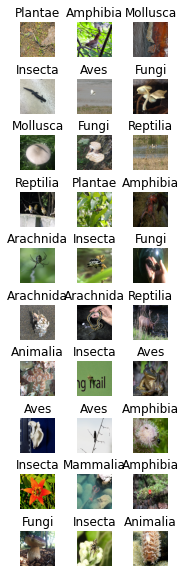

In [ ]:
show_grid(X_test, 10, 3, label_list = labels_test, show_labels = True, figsize = (20,10))

# **Save Model:**

---



In [ ]:
with h5py.File("model1_s.hdf5", "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='i')

In [ ]:
#Serialize to JSON
json_file = model.to_json()
with open('/content/drive/MyDrive/DL_Assignment 2/model_s.json', "w") as file:
   file.write(json_file)
#Serialize weights to HDF5
model.save_weights('model1_s.hdf5')

#**Sweeps on Filter Organisation and Batch Normalisation:**

---

In [ ]:
sweep_config_2 = {
    'method': 'random',
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'filter_org': {
            'values': [0.5, 1, 2]
        },
        'batch_normalization': {
            'values': ['true', 'false']
        }
    }
}

sweep_id_2 = wandb.sweep(sweep_config_2, project = 'cs6910-assignment-2')

In [ ]:
def Convolution_Network_2():

  #Default Values
  image_size = 224
  w_init = 'he_normal'
  S = 2
  epoch = 10
  batch_size = 64
  K1 = 32
  K2 = 32
  K3 = 32
  K4 = 64
  K5 = 64
  F = 3
  dropout = 0.3
  augment = 'false'
  dense_units = 500
  activation = 'relu'
  no_of_labels = 10

  #Sweep defaults
  config_defaults = {
      'filter_org': 1,
      'batch_normalization': 'false'
  }
      
  wandb.init(project = 'cs6910-assignment-2', config = config_defaults)
  config = wandb.config
  name = "BS=" + str(batch_size) + "_ACT=" + str(activation) + "_Dropout=" + str(dropout)
  wandb.init().name = name

  filter_org = config.filter_org
  batch_normalization = config.batch_normalization

  #CNN
  model = Sequential()
      
  #Layer 1
  model.add(Conv2D(filters = K1, kernel_size = (F,F), input_shape = image_batch_train.shape[1:], padding ='same', kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = S))

  #Layer 2
  model.add(Conv2D(filters = (K1 * filter_org), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

  #Layer 3
  model.add(Conv2D(filters = (K1 * filter_org**2), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

  #Layer 4
  model.add(Conv2D(filters = K1 * (filter_org ** 3), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

  #Layer 5
  model.add(Conv2D(filters = K1 * (filter_org ** 4), kernel_size = (F, F), padding ='same', kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = S))

  #FC1
  model.add(Flatten())
  model.add(Dense(dense_units, kernel_initializer = w_init))
  if batch_normalization == 'true':
    model.add(BatchNormalization())
  else :
    pass

  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  #Output layer
  model.add(Dense(no_of_labels, kernel_initializer = 'glorot_normal'))
  model.add(Activation('softmax'))

  model.compile(optimizer = 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
  hist = model.fit(train, epochs = epoch, validation_data = val, batch_size = batch_size)
  model.summary()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  for i in range(epoch):
    wandb.log({'training_loss': loss[i]})
    wandb.log({'validation_loss': val_loss[i]})
    wandb.log({'training_accuracy': acc[i]})
    wandb.log({'validation_accuracy': val_acc[i]})                          

In [ ]:
wandb.agent(sweep_id_2, function = Convolution_Network_2)

wandb: Agent Starting Run: 210mel50 with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 4774s 17s/step - loss: 2.3335 - accuracy: 0.1317 - val_loss: 2.1507 - val_accuracy: 0.2150
Epoch 2/10
282/282 [==============================] - 252s 895ms/step - loss: 2.1148 - accuracy: 0.2307 - val_loss: 1.9939 - val_accuracy: 0.2990
Epoch 3/10
282/282 [==============================] - 250s 885ms/step - loss: 1.9922 - accuracy: 0.2950 - val_loss: 1.9206 - val_accuracy: 0.3200
Epoch 4/10
282/282 [==============================] - 249s 884ms/step - loss: 1.9178 - accuracy: 0.3182 - val_loss: 1.9043 - val_accuracy: 0.3450
Epoch 5/10
282/282 [==============================] - 249s 882ms/step - loss: 1.8577 - accuracy: 0.3393 - val_loss: 1.8623 - val_accuracy: 0.3490
Epoch 6/10
282/282 [==============================] - 249s 883ms/step - loss: 1.8124 - accuracy: 0.3609 - val_loss: 1.8359 - val_accuracy: 0.3590
Epoch 7/10
282/282 [==============================] - 252s 893ms/step - loss: 1.7802 - accuracy: 0.3737 - val_loss: 1.8203 - 

training_loss,1.66651
_runtime,7030
_timestamp,1618336471
_step,39
validation_loss,1.84487
training_accuracy,0.40978
validation_accuracy,0.377


training_loss,█▆▅▄▃▃▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▂
training_accuracy,▁▄▅▆▆▇▇▇██
validation_accuracy,▁▅▅▆▇▇▇▇██


wandb: Agent Starting Run: 5xu9kbeh with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 250s 882ms/step - loss: 2.2932 - accuracy: 0.1418 - val_loss: 2.1063 - val_accuracy: 0.2420
Epoch 2/10
282/282 [==============================] - 249s 882ms/step - loss: 2.0836 - accuracy: 0.2414 - val_loss: 1.9502 - val_accuracy: 0.3200
Epoch 3/10
282/282 [==============================] - 250s 887ms/step - loss: 1.9808 - accuracy: 0.2899 - val_loss: 2.0359 - val_accuracy: 0.3160
Epoch 4/10
282/282 [==============================] - 249s 881ms/step - loss: 1.8994 - accuracy: 0.3234 - val_loss: 1.8804 - val_accuracy: 0.3390
Epoch 5/10
282/282 [==============================] - 253s 898ms/step - loss: 1.8344 - accuracy: 0.3530 - val_loss: 1.9047 - val_accuracy: 0.3500
Epoch 6/10
282/282 [==============================] - 253s 896ms/step - loss: 1.7892 - accuracy: 0.3715 - val_loss: 1.8290 - val_accuracy: 0.3820
Epoch 7/10
282/282 [==============================] - 250s 887ms/step - loss: 1.7499 - accuracy: 0.3767 - val_loss: 1.8435 -

training_loss,1.62965
_runtime,2509
_timestamp,1618338996
_step,39
validation_loss,1.7954
training_accuracy,0.42189
validation_accuracy,0.397


training_loss,█▆▅▄▃▃▃▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▅▆▃▄▂▂▁▃▁
training_accuracy,▁▃▄▅▆▆▇▇██
validation_accuracy,▁▅▄▅▆▇▆▇▆█


wandb: Agent Starting Run: 16iqw9px with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 257s 904ms/step - loss: 2.4545 - accuracy: 0.2060 - val_loss: 2.1144 - val_accuracy: 0.2890
Epoch 2/10
282/282 [==============================] - 256s 909ms/step - loss: 2.0348 - accuracy: 0.2963 - val_loss: 2.2310 - val_accuracy: 0.2810
Epoch 3/10
282/282 [==============================] - 256s 909ms/step - loss: 1.8816 - accuracy: 0.3469 - val_loss: 2.1438 - val_accuracy: 0.2650
Epoch 4/10
282/282 [==============================] - 256s 906ms/step - loss: 1.7878 - accuracy: 0.3809 - val_loss: 2.3559 - val_accuracy: 0.2680
Epoch 5/10
282/282 [==============================] - 256s 908ms/step - loss: 1.7085 - accuracy: 0.4010 - val_loss: 2.0348 - val_accuracy: 0.3450
Epoch 6/10
282/282 [==============================] - 254s 902ms/step - loss: 1.6132 - accuracy: 0.4469 - val_loss: 2.1572 - val_accuracy: 0.3450
Epoch 7/10
282/282 [==============================] - 256s 907ms/step - loss: 1.5529 - accuracy: 0.4565 - val_loss: 1.8890 -

training_loss,1.3899
_runtime,2568
_timestamp,1618341580
_step,39
validation_loss,1.94565
training_accuracy,0.51656
validation_accuracy,0.395


training_loss,█▆▅▄▄▃▂▂▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,▅▇▆█▄▆▃▃▁▃
training_accuracy,▁▃▄▄▅▆▆▇▇█
validation_accuracy,▂▂▁▁▅▅█▆█▇


wandb: Agent Starting Run: rlj4jjyl with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 252s 891ms/step - loss: 2.2998 - accuracy: 0.1091 - val_loss: 2.2963 - val_accuracy: 0.1460
Epoch 2/10
282/282 [==============================] - 250s 887ms/step - loss: 2.2856 - accuracy: 0.1330 - val_loss: 2.2737 - val_accuracy: 0.1370
Epoch 3/10
282/282 [==============================] - 249s 884ms/step - loss: 2.2594 - accuracy: 0.1548 - val_loss: 2.2440 - val_accuracy: 0.1520
Epoch 4/10
282/282 [==============================] - 249s 882ms/step - loss: 2.2281 - accuracy: 0.1837 - val_loss: 2.1676 - val_accuracy: 0.1920
Epoch 5/10
282/282 [==============================] - 249s 884ms/step - loss: 2.1561 - accuracy: 0.2193 - val_loss: 2.1233 - val_accuracy: 0.2320
Epoch 6/10
282/282 [==============================] - 252s 893ms/step - loss: 2.0935 - accuracy: 0.2481 - val_loss: 2.0961 - val_accuracy: 0.2350
Epoch 7/10
282/282 [==============================] - 252s 895ms/step - loss: 2.0687 - accuracy: 0.2586 - val_loss: 2.0594 -

training_loss,1.99767
_runtime,2510
_timestamp,1618344105
_step,39
validation_loss,2.043
training_accuracy,0.28089
validation_accuracy,0.284


training_loss,██▇▆▄▃▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▇▇▅▄▃▂▃▁▂
training_accuracy,▁▂▃▄▅▆▇▇██
validation_accuracy,▁▁▂▄▆▆▆▆██


wandb: Agent Starting Run: yjln9al0 with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 256s 903ms/step - loss: 2.5304 - accuracy: 0.1496 - val_loss: 2.2411 - val_accuracy: 0.1720
Epoch 2/10
282/282 [==============================] - 250s 887ms/step - loss: 2.2747 - accuracy: 0.2045 - val_loss: 2.2234 - val_accuracy: 0.2340
Epoch 3/10
282/282 [==============================] - 248s 880ms/step - loss: 2.1543 - accuracy: 0.2342 - val_loss: 2.1681 - val_accuracy: 0.2460
Epoch 4/10
282/282 [==============================] - 249s 882ms/step - loss: 2.0863 - accuracy: 0.2523 - val_loss: 2.2253 - val_accuracy: 0.2410
Epoch 5/10
282/282 [==============================] - 248s 880ms/step - loss: 2.0325 - accuracy: 0.2823 - val_loss: 2.1401 - val_accuracy: 0.2660
Epoch 6/10
282/282 [==============================] - 248s 880ms/step - loss: 2.0231 - accuracy: 0.2805 - val_loss: 2.2172 - val_accuracy: 0.2560
Epoch 7/10
282/282 [==============================] - 249s 884ms/step - loss: 1.9747 - accuracy: 0.2970 - val_loss: 2.0483 -

training_loss,1.94183
_runtime,2500
_timestamp,1618346622
_step,39
validation_loss,1.99546
training_accuracy,0.30811
validation_accuracy,0.299


training_loss,█▅▄▃▂▂▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,██▆█▅▇▃▁▄▁
training_accuracy,▁▃▅▅▆▆▇▇██
validation_accuracy,▁▄▅▅▆▅▇█▆█


wandb: Agent Starting Run: 4sendr7n with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 254s 895ms/step - loss: 3.5813 - accuracy: 0.1323 - val_loss: 2.1423 - val_accuracy: 0.2350
Epoch 2/10
282/282 [==============================] - 252s 892ms/step - loss: 2.2150 - accuracy: 0.1977 - val_loss: 2.0976 - val_accuracy: 0.2450
Epoch 3/10
282/282 [==============================] - 251s 891ms/step - loss: 2.0852 - accuracy: 0.2673 - val_loss: 1.9860 - val_accuracy: 0.2990
Epoch 4/10
282/282 [==============================] - 252s 893ms/step - loss: 1.9908 - accuracy: 0.2938 - val_loss: 1.9645 - val_accuracy: 0.3180
Epoch 5/10
282/282 [==============================] - 252s 895ms/step - loss: 1.9351 - accuracy: 0.3139 - val_loss: 1.9347 - val_accuracy: 0.3150
Epoch 6/10
282/282 [==============================] - 251s 890ms/step - loss: 1.8480 - accuracy: 0.3540 - val_loss: 1.9114 - val_accuracy: 0.3310
Epoch 7/10
282/282 [==============================] - 251s 891ms/step - loss: 1.8117 - accuracy: 0.3676 - val_loss: 1.9448 -

training_loss,1.66817
_runtime,2526
_timestamp,1618349162
_step,39
validation_loss,1.84359
training_accuracy,0.41544
validation_accuracy,0.367


training_loss,█▅▄▄▃▃▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▇▄▄▃▃▃▂▂▁
training_accuracy,▁▃▄▅▆▆▇▇▇█
validation_accuracy,▁▂▄▅▅▆▆▇██


wandb: Agent Starting Run: 0vw2b7w4 with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 248s 876ms/step - loss: 2.3083 - accuracy: 0.1061 - val_loss: 2.2881 - val_accuracy: 0.1180
Epoch 2/10
282/282 [==============================] - 245s 870ms/step - loss: 2.2777 - accuracy: 0.1361 - val_loss: 2.2603 - val_accuracy: 0.1500
Epoch 3/10
282/282 [==============================] - 244s 866ms/step - loss: 2.2469 - accuracy: 0.1526 - val_loss: 2.2262 - val_accuracy: 0.1740
Epoch 4/10
282/282 [==============================] - 242s 860ms/step - loss: 2.1963 - accuracy: 0.1956 - val_loss: 2.1551 - val_accuracy: 0.2300
Epoch 5/10
282/282 [==============================] - 245s 869ms/step - loss: 2.1400 - accuracy: 0.2233 - val_loss: 2.1675 - val_accuracy: 0.2420
Epoch 6/10
282/282 [==============================] - 244s 864ms/step - loss: 2.0938 - accuracy: 0.2493 - val_loss: 2.1244 - val_accuracy: 0.2420
Epoch 7/10
282/282 [==============================] - 240s 851ms/step - loss: 2.0650 - accuracy: 0.2585 - val_loss: 2.0638 -

training_loss,1.98698
_runtime,2432
_timestamp,1618351609
_step,39
validation_loss,2.01061
training_accuracy,0.29278
validation_accuracy,0.292


training_loss,█▇▇▅▄▃▃▂▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▇▆▅▅▄▂▁▂▁
training_accuracy,▁▂▃▅▆▆▇█▇█
validation_accuracy,▁▂▃▆▆▆▇▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9sbelmsu with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 247s 871ms/step - loss: 2.3682 - accuracy: 0.2156 - val_loss: 2.0580 - val_accuracy: 0.2770
Epoch 2/10
282/282 [==============================] - 245s 870ms/step - loss: 2.0102 - accuracy: 0.2934 - val_loss: 2.3601 - val_accuracy: 0.2870
Epoch 3/10
282/282 [==============================] - 246s 873ms/step - loss: 1.9116 - accuracy: 0.3374 - val_loss: 2.3655 - val_accuracy: 0.2970
Epoch 4/10
282/282 [==============================] - 246s 872ms/step - loss: 1.8181 - accuracy: 0.3541 - val_loss: 2.4648 - val_accuracy: 0.2770
Epoch 5/10
282/282 [==============================] - 246s 874ms/step - loss: 1.7661 - accuracy: 0.3895 - val_loss: 2.2677 - val_accuracy: 0.3000
Epoch 6/10
282/282 [==============================] - 246s 873ms/step - loss: 1.6765 - accuracy: 0.4118 - val_loss: 1.8871 - val_accuracy: 0.3830
Epoch 7/10
282/282 [==============================] - 247s 874ms/step - loss: 1.6564 - accuracy: 0.4291 - val_loss: 2.5042 -

training_loss,1.51997
_runtime,2485
_timestamp,1618354119
_step,39
validation_loss,1.78659
training_accuracy,0.47122
validation_accuracy,0.409


training_loss,█▆▅▄▃▃▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,▄▇▇█▆▂█▆▂▁
training_accuracy,▁▂▄▄▅▆▇▇▇█
validation_accuracy,▁▂▂▁▂▇▂▃▆█


wandb: Agent Starting Run: a3km52uf with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
282/282 [==============================] - 259s 915ms/step - loss: 2.3554 - accuracy: 0.2170 - val_loss: 2.2477 - val_accuracy: 0.2350
Epoch 2/10
282/282 [==============================] - 258s 914ms/step - loss: 2.0423 - accuracy: 0.2961 - val_loss: 2.3143 - val_accuracy: 0.3230
Epoch 3/10
282/282 [==============================] - 254s 902ms/step - loss: 1.8966 - accuracy: 0.3385 - val_loss: 2.0063 - val_accuracy: 0.3410
Epoch 4/10
282/282 [==============================] - 252s 894ms/step - loss: 1.7975 - accuracy: 0.3727 - val_loss: 3.3179 - val_accuracy: 0.2120
Epoch 5/10
282/282 [==============================] - 256s 908ms/step - loss: 1.7118 - accuracy: 0.4042 - val_loss: 2.3656 - val_accuracy: 0.3120
Epoch 6/10
282/282 [==============================] - 257s 912ms/step - loss: 1.6318 - accuracy: 0.4265 - val_loss: 2.5699 - val_accuracy: 0.3170
Epoch 7/10
282/282 [==============================] - 255s 904ms/step - loss: 1.5597 - accuracy: 0.4572 - val_loss: 2.4426 -

training_loss,1.40511
_runtime,2566
_timestamp,1618356705
_step,39
validation_loss,2.03906
training_accuracy,0.51333
validation_accuracy,0.381


training_loss,█▆▅▄▄▃▂▂▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,▃▃▂█▃▄▄▃▁▂
training_accuracy,▁▂▃▅▅▆▆▇▇█
validation_accuracy,▂▅▅▁▄▄▄▄█▆


wandb: Agent Starting Run: ku41nru2 with config:
wandb: 	batch_normalization: false
wandb: 	filter_org: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 249s 881ms/step - loss: 2.3055 - accuracy: 0.1149 - val_loss: 2.2664 - val_accuracy: 0.1530
Epoch 2/10
282/282 [==============================] - 247s 877ms/step - loss: 2.2265 - accuracy: 0.1735 - val_loss: 2.2102 - val_accuracy: 0.1920
Epoch 3/10
282/282 [==============================] - 247s 875ms/step - loss: 2.1431 - accuracy: 0.2157 - val_loss: 2.1343 - val_accuracy: 0.2130
Epoch 4/10
282/282 [==============================] - 247s 875ms/step - loss: 2.1138 - accuracy: 0.2357 - val_loss: 2.1199 - val_accuracy: 0.2340
Epoch 5/10
282/282 [==============================] - 249s 882ms/step - loss: 2.0718 - accuracy: 0.2532 - val_loss: 2.1168 - val_accuracy: 0.2530
Epoch 6/10
282/282 [==============================] - 248s 881ms/step - loss: 2.0486 - accuracy: 0.2629 - val_loss: 2.0536 - val_accuracy: 0.2730
Epoch 7/10
282/282 [==============================] - 249s 883ms/step - loss: 2.0119 - accuracy: 0.2710 - val_loss: 2.0370 -

training_loss,1.98074
_runtime,2485
_timestamp,1618359210
_step,39
validation_loss,2.03036
training_accuracy,0.29422
validation_accuracy,0.277


training_loss,█▆▅▄▃▂▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▆▄▄▄▂▁▁▁▁
training_accuracy,▁▃▅▆▆▇▇▇██
validation_accuracy,▁▃▄▆▇█▇███


wandb: Agent Starting Run: h9bwyza5 with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 258s 910ms/step - loss: 2.3752 - accuracy: 0.2109 - val_loss: 2.2088 - val_accuracy: 0.2680
Epoch 2/10
282/282 [==============================] - 253s 899ms/step - loss: 2.0212 - accuracy: 0.2939 - val_loss: 2.1271 - val_accuracy: 0.3220
Epoch 3/10
282/282 [==============================] - 252s 893ms/step - loss: 1.8881 - accuracy: 0.3364 - val_loss: 2.1595 - val_accuracy: 0.3200
Epoch 4/10
282/282 [==============================] - 252s 893ms/step - loss: 1.8456 - accuracy: 0.3547 - val_loss: 2.1806 - val_accuracy: 0.2780
Epoch 5/10
282/282 [==============================] - 248s 881ms/step - loss: 1.7584 - accuracy: 0.3839 - val_loss: 2.5173 - val_accuracy: 0.2790
Epoch 6/10
282/282 [==============================] - 251s 892ms/step - loss: 1.6933 - accuracy: 0.4030 - val_loss: 1.8445 - val_accuracy: 0.3700
Epoch 7/10
282/282 [==============================] - 254s 901ms/step - loss: 1.6681 - accuracy: 0.4176 - val_loss: 2.0486 -

training_loss,1.55061
_runtime,2534
_timestamp,1618361761
_step,39
validation_loss,1.82948
training_accuracy,0.45622
validation_accuracy,0.396


training_loss,█▆▄▄▃▃▂▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,▅▄▄▅█▁▃▆▂▁
training_accuracy,▁▃▄▅▅▆▇▇██
validation_accuracy,▁▄▄▂▂▇▄▅▅█


wandb: Agent Starting Run: knvfoq81 with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 256s 902ms/step - loss: 2.4729 - accuracy: 0.1510 - val_loss: 2.2976 - val_accuracy: 0.1600
Epoch 2/10
282/282 [==============================] - 254s 900ms/step - loss: 2.2381 - accuracy: 0.1973 - val_loss: 2.1719 - val_accuracy: 0.2370
Epoch 3/10
282/282 [==============================] - 252s 892ms/step - loss: 2.1471 - accuracy: 0.2350 - val_loss: 2.1073 - val_accuracy: 0.2320
Epoch 4/10
282/282 [==============================] - 253s 898ms/step - loss: 2.0962 - accuracy: 0.2516 - val_loss: 2.0836 - val_accuracy: 0.2750
Epoch 5/10
282/282 [==============================] - 256s 907ms/step - loss: 2.0540 - accuracy: 0.2539 - val_loss: 2.0877 - val_accuracy: 0.2580
Epoch 6/10
282/282 [==============================] - 255s 902ms/step - loss: 2.0070 - accuracy: 0.2814 - val_loss: 2.0575 - val_accuracy: 0.2750
Epoch 7/10
282/282 [==============================] - 254s 902ms/step - loss: 1.9800 - accuracy: 0.2875 - val_loss: 2.0750 -

training_loss,1.93906
_runtime,2540
_timestamp,1618364316
_step,39
validation_loss,2.10355
training_accuracy,0.30878
validation_accuracy,0.281


training_loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_loss,█▅▄▃▃▂▃▁▃▃
training_accuracy,▁▃▅▅▆▆▇▇██
validation_accuracy,▁▅▅▇▆▇▇█▇▇


wandb: Agent Starting Run: hchir0yl with config:
wandb: 	batch_normalization: true
wandb: 	filter_org: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 260s 917ms/step - loss: 2.3837 - accuracy: 0.2153 - val_loss: 2.1242 - val_accuracy: 0.2360
Epoch 2/10
282/282 [==============================] - 258s 913ms/step - loss: 2.0515 - accuracy: 0.2906 - val_loss: 2.1214 - val_accuracy: 0.3090
Epoch 3/10
282/282 [==============================] - 257s 910ms/step - loss: 1.9501 - accuracy: 0.3323 - val_loss: 2.7911 - val_accuracy: 0.2820
Epoch 4/10


#**Guided Backpropagation code and importing saved models:**

---

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad
  
class GuidedBackprop:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gbp_model = self.build_guided_model()

    def build_guided_model(self):
        gbp_model = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layer_name).output]
        )
        gbp_layers = [layer for layer in gbp_model.layers[1:] if hasattr(layer, "activation")]
        for layer in gbp_layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbp_model
    
    def guided_backprop(self, images, upsample_size):
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbp_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
#Load and create model
json_file = open('/content/drive/MyDrive/DL_Assignment 2/model_s.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#Load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/DL_Assignment 2/model1_s.hdf5")
print("Loaded model from disk")

Loaded model from disk


#**Displaying Guided-Backpropagated images and excited neurons:**

---

In [ ]:
def show_grid_2(img, nrows, ncols, showaxis='off'):
    _, axs = plt.subplots(nrows, ncols, figsize = (12, 12))
    axs = axs.flatten()
    for img, ax in zip(img, axs):
      ax.imshow(img)
      ax.axis('off')
    plt.show()

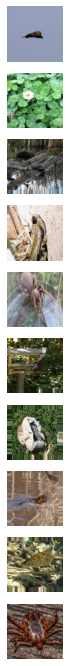

In [ ]:
show_grid_2(X, 10, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

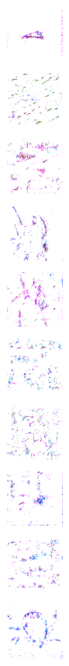

In [ ]:
layer_name = loaded_model.layers[13].name
target_size = (224, 224)
img = X
for i in range(10):
  img_temp = X[i]
  guidedBP = GuidedBackprop(model = loaded_model, layerName = layer_name) 
  gb_cam = guidedBP.guided_backprop(np.expand_dims(img_temp, axis = 0), target_size)
  img[i] = deprocess_image(gb_cam)
  img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
show_grid_2(img, 10, 1)